In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sphincter.data_preparation import load_prepared_data
import os
import arviz as az

In [2]:
PLOTS_DIR = os.path.join("..", "plots")
IDATA_PATH = os.path.join("..", "inferences", "flow-basic", "idata")

In [3]:
raw = pd.read_csv("../data/raw/data_sphincter_paper.csv")
prepped = load_prepared_data("../data/prepared/flow.json")

In [4]:
msts = prepped.measurements
msts.head()

,age,mouse,vessel_type,treatment,pressure_d,diameter,speed,flux
950,adult,100920,sphincter,baseline,53.504977,NaN,6.063019,383.344348
958,adult,100920,sphincter,hyper,NaN,NaN,14.819332,NaN
791,adult,130520,bulb,baseline,40.170137,NaN,0.765028,NaN
792,adult,130520,cap1,baseline,40.410177,NaN,1.781879,NaN
793,adult,130520,cap2,baseline,41.093826,NaN,0.629455,49.492191


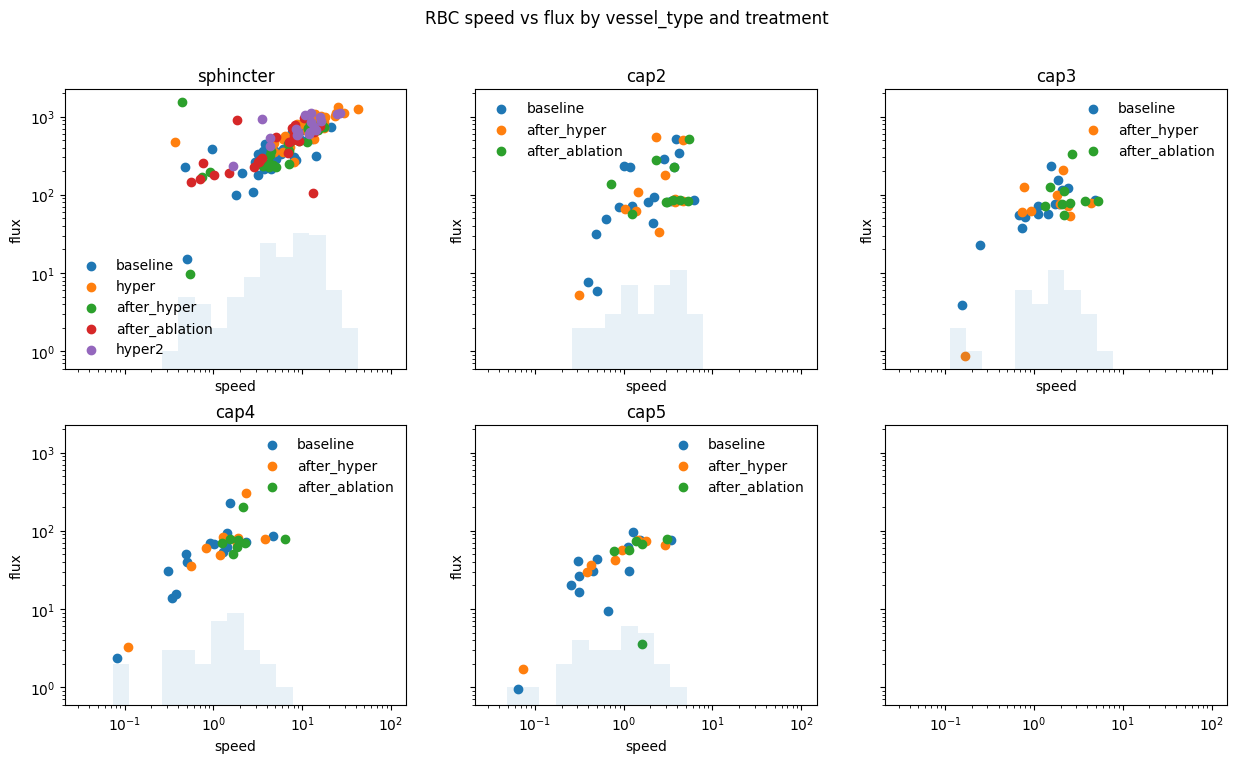

In [5]:
f, axes = plt.subplots(2, 3, figsize=[15, 8], sharex=True, sharey=True)
axes = axes.ravel()

G1 = "vessel_type"
G2 = "treatment"
title = f"RBC speed vs flux by {G1} and {G2}"

for ax, g1 in zip(axes, msts.dropna(subset=["speed", "flux"])[G1].unique()):
    subdf = msts.loc[lambda df: df[G1] == g1]
    for g2, subsubdf in subdf.groupby(G2, observed=True):
        ax.scatter(subsubdf["speed"], subsubdf["flux"], label=g2)
    ax.hist(subdf["speed"], bins=np.logspace(-1.5, 2, 20), alpha=0.1)
    ax.legend(frameon=False)
    ax.semilogx()
    ax.semilogy()
    ax.set(title=g1, xlabel="speed", ylabel="flux")

f.suptitle(title)
f.savefig(os.path.join(PLOTS_DIR, f"{title.lower().replace(' ', '-')}.png"), bbox_inches="tight")

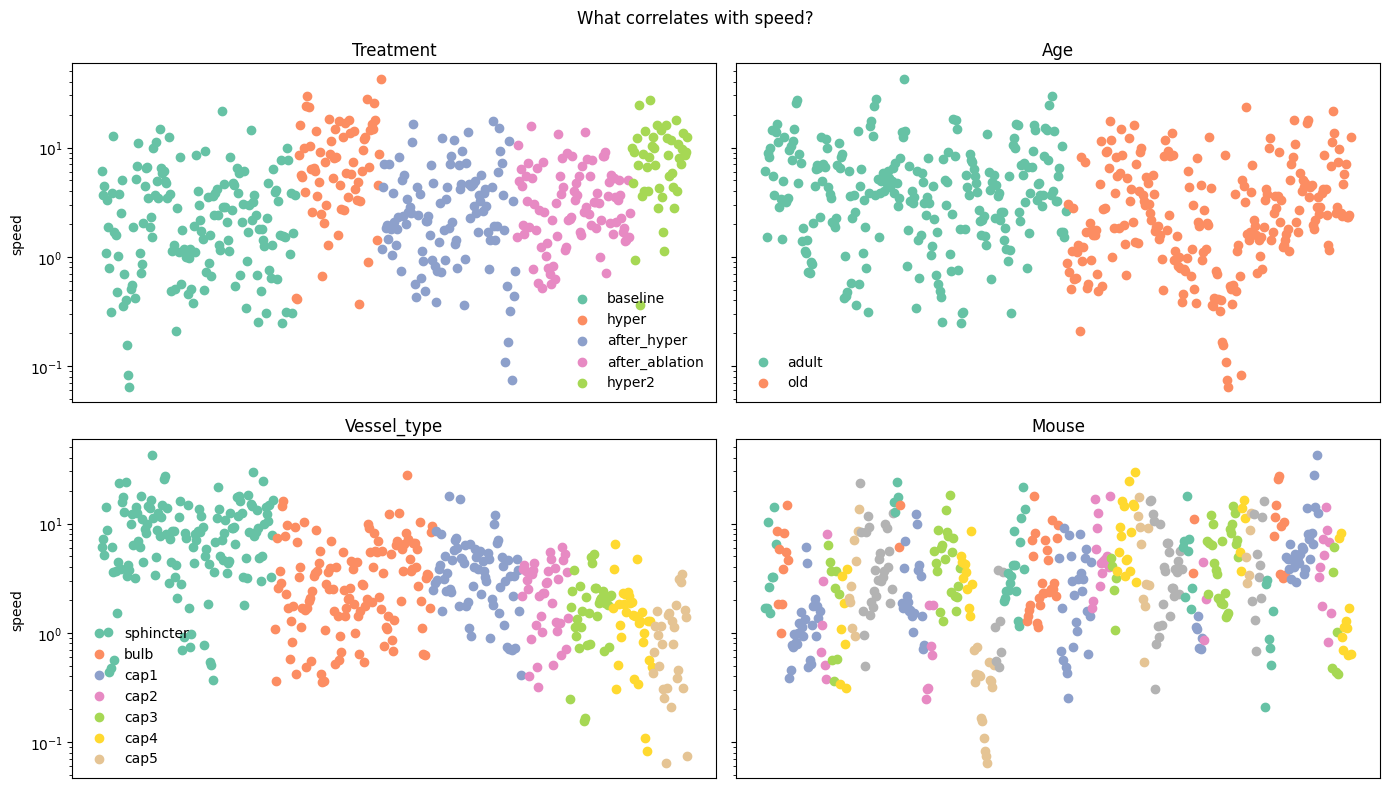

In [6]:
def plot_obs_cat(ax, obs, catcol, cmap, extra_obs=None, **scatter_kwargs):
    colors = list(cmap.colors)
    d_dict = {"obs": obs, "cat": catcol}
    if extra_obs is not None:
        d_dict["extra"] = extra_obs
    d = pd.DataFrame(d_dict).sort_values("cat").assign(x=np.linspace(0, 1, len(obs)))
    scts = []
    for i, (cat, subdf) in enumerate(d.groupby("cat", observed=True)):
        color = colors[i % len(colors)]
        scts.append(ax.scatter(subdf["x"], subdf["obs"], label=cat, color=color, **scatter_kwargs))
        if extra_obs is not None:
            scts.append(ax.scatter(subdf["x"], subdf["extra"], marker="x", label=extra_obs.name, color="black"))            
    return scts


obs = msts["speed"]
cmap = plt.get_cmap("Set2")

f, axes = plt.subplots(2, 2, figsize=[14, 8], sharey=True)
axes = axes.ravel()
for (i, ax), col in zip(enumerate(axes), ["treatment", "age", "vessel_type", "mouse"]):
    catcol = msts[col]
    sct = plot_obs_cat(ax, obs, catcol, cmap)
    if col != "mouse":
        ax.legend(frameon=False);
    if i % 2 == 0:
        ax.set_ylabel("speed");
    ax.set_xticks([])
    ax.set_title(col.capitalize())
    ax.semilogy()
f.suptitle("What correlates with speed?");
f.tight_layout()
# f.savefig(os.path.join(PLOTS_DIR, "pulsatility-diameter-measurements.png"), bbox_inches="tight")


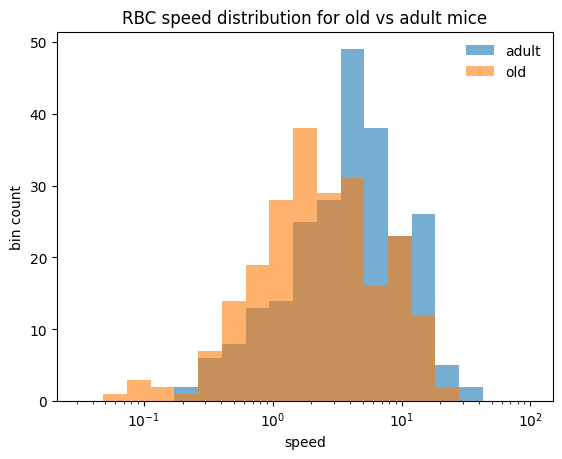

In [7]:
f, ax = plt.subplots()

for age, subdf in msts.groupby("age", observed=True):
    ax.hist(subdf["speed"], label=age, bins=np.logspace(-1.5, 2, 20), alpha=0.6);
ax.semilogx()
ax.legend(frameon=False);
ax.set(title="RBC speed distribution for old vs adult mice", xlabel="speed", ylabel="bin count");

f.savefig(os.path.join(PLOTS_DIR, "rbc-speed-vs-age.png"))

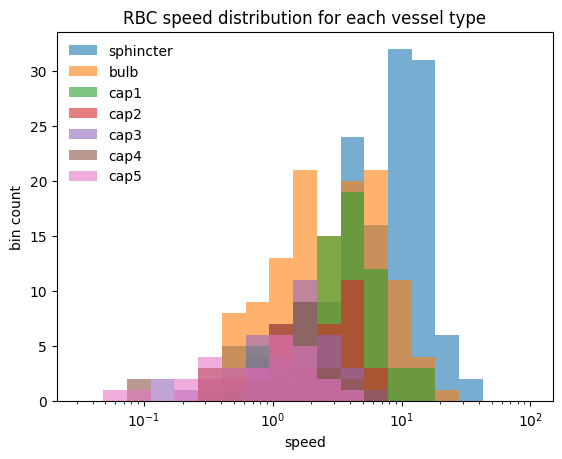

In [8]:
f, ax = plt.subplots()

for age, subdf in msts.groupby("vessel_type", observed=True):
    ax.hist(subdf["speed"], label=age, bins=np.logspace(-1.5, 2, 20), alpha=0.6);
ax.semilogx()
ax.legend(frameon=False);
ax.set(title="RBC speed distribution for each vessel type", xlabel="speed", ylabel="bin count");

f.savefig(os.path.join(PLOTS_DIR, "rbc-speed-vs-vessel-type.png"))

In [9]:
msts["treatment"].cat.categories

Index(['baseline', 'hyper', 'after_hyper', 'after_ablation', 'hyper2'], dtype='object')

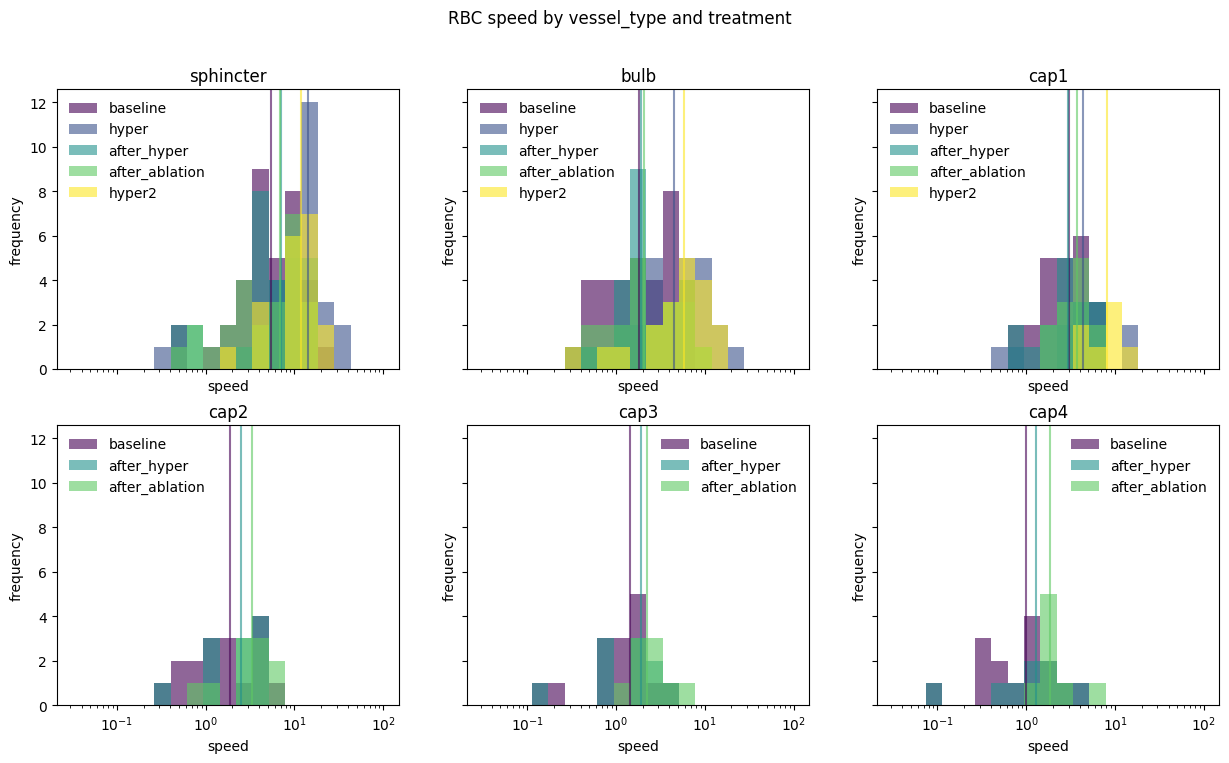

In [10]:
cmap = plt.get_cmap('viridis')

def cats_to_cols(cats, cmap):
    return dict(zip(cats, cmap(np.linspace(0, 1, len(cats)))))

treatment_to_color = cats_to_cols(msts["treatment"].cat.categories, cmap)

f, axes = plt.subplots(2, 3, figsize=[15, 8], sharex=True, sharey=True)
axes = axes.ravel()

G1 = "vessel_type"
G2 = "treatment"
title = f"RBC speed by {G1} and {G2}"

for ax, g1 in zip(axes, msts.dropna(subset=["speed"])[G1].unique()):
    subdf = msts.loc[lambda df: df[G1] == g1]
    for g2, subsubdf in subdf.groupby(G2, observed=True):
        h = ax.hist(subsubdf["speed"], bins=np.logspace(-1.5, 2, 20), alpha=0.6, label=g2, color=treatment_to_color[g2])
        ax.axvline(subsubdf["speed"].median(), color=h[2][0].get_facecolor())
    ax.legend(frameon=False)
    ax.semilogx()
    ax.set(title=g1, xlabel="speed", ylabel="frequency")

f.suptitle(title);
f.savefig(os.path.join(PLOTS_DIR, f"{title.lower().replace(' ', '-')}.png"), bbox_inches="tight")

In [29]:
msts.groupby(["vessel_type", "treatment"])["speed"].mean().unstack("vessel_type")

/var/folders/ql/z_6fb5792v1_8tscf4hg5byc0000gp/T/ipykernel_39623/3991435316.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  msts.groupby(["vessel_type", "treatment"])["speed"].mean().unstack("vessel_type")


vessel_type,sphincter,bulb,cap1,cap2,cap3,cap4,cap5
treatment,,,,,,,
baseline,6.733814,2.528891,3.090758,2.163653,1.518498,1.206113,0.828489
hyper,14.266310,6.166937,5.475803,NaN,NaN,NaN,NaN
after_hyper,7.261837,2.761624,3.288263,2.622123,1.780132,1.546503,1.099711
after_ablation,6.142304,3.075481,3.956487,3.275713,2.625419,2.384274,1.608535
hyper2,11.612087,6.121866,8.589743,NaN,NaN,NaN,NaN


In [11]:
idata = az.InferenceData.from_zarr(IDATA_PATH)

idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> sample_stats_prior
	> observed_data

In [12]:
az.summary(idata, var_names=["sigma", "sigma_std"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.411,0.014,0.387,0.437,0.0,0.0,6758.0,2535.0,1.0
sigma_std,0.369,0.012,0.347,0.393,0.0,0.0,6758.0,2535.0,1.0


In [13]:
az.loo(idata)

Computed from 4000 posterior samples and 465 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -204.70    18.21
p_loo       16.29        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      465  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [14]:
print(f"Number of diverging transitions: " +  str(idata.sample_stats.diverging.values.sum()))

Number of diverging transitions: 0


# Inspect samples


Try a different model for the interaction effect - maybe being shrunk too hard towards zero.

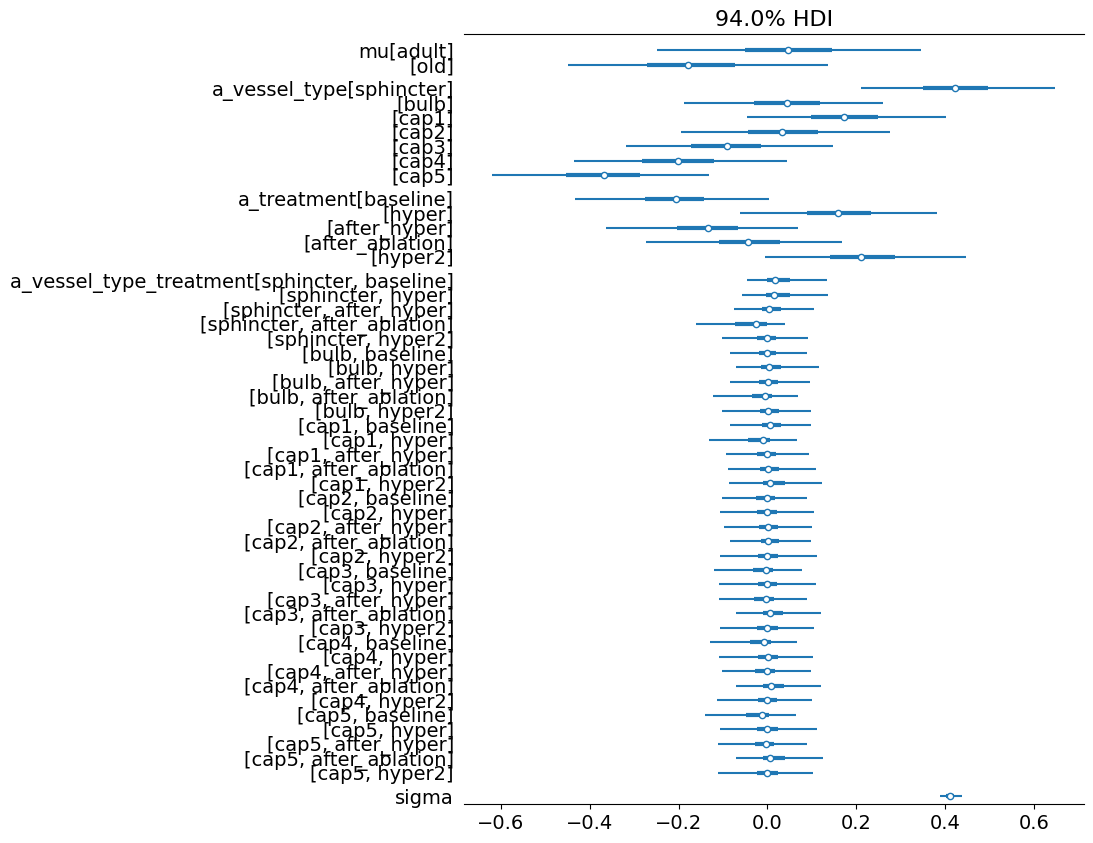

In [15]:
vars = ["mu", "a_vessel_type", "a_treatment", "a_vessel_type_treatment", "sigma"]
f, ax = plt.subplots(figsize=[8, 10], sharex=True)
az.plot_forest(
    idata,
    ax=ax,
    combined=True,
    var_names=vars,
);


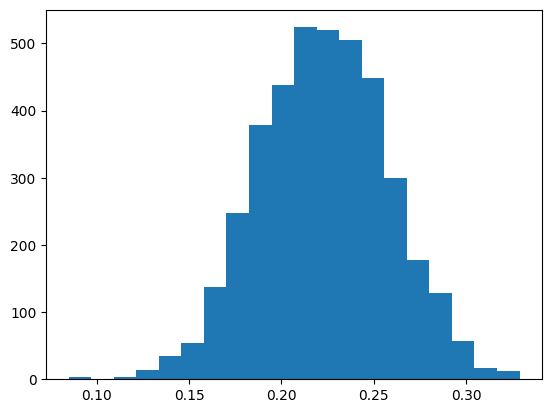

In [22]:
t = idata.posterior["mu"].sel(age="adult") - idata.posterior["mu"].sel(age="old")

plt.hist(t.values.flatten(), bins=20);



0.94375


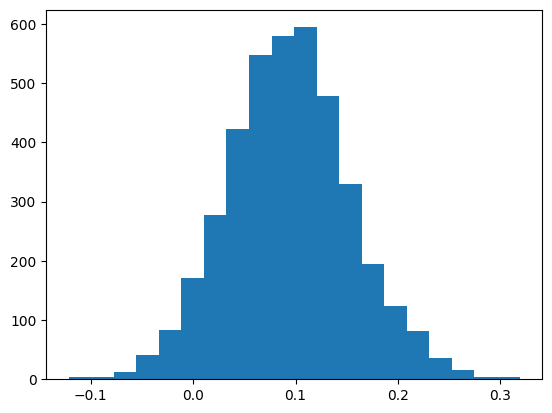

In [26]:
t = idata.posterior["a_treatment"].sel(treatment="after_ablation") - idata.posterior["a_treatment"].sel(treatment="after_hyper")

print((t > 0).mean().values[()])

plt.hist(t.values.flatten(), bins=20);

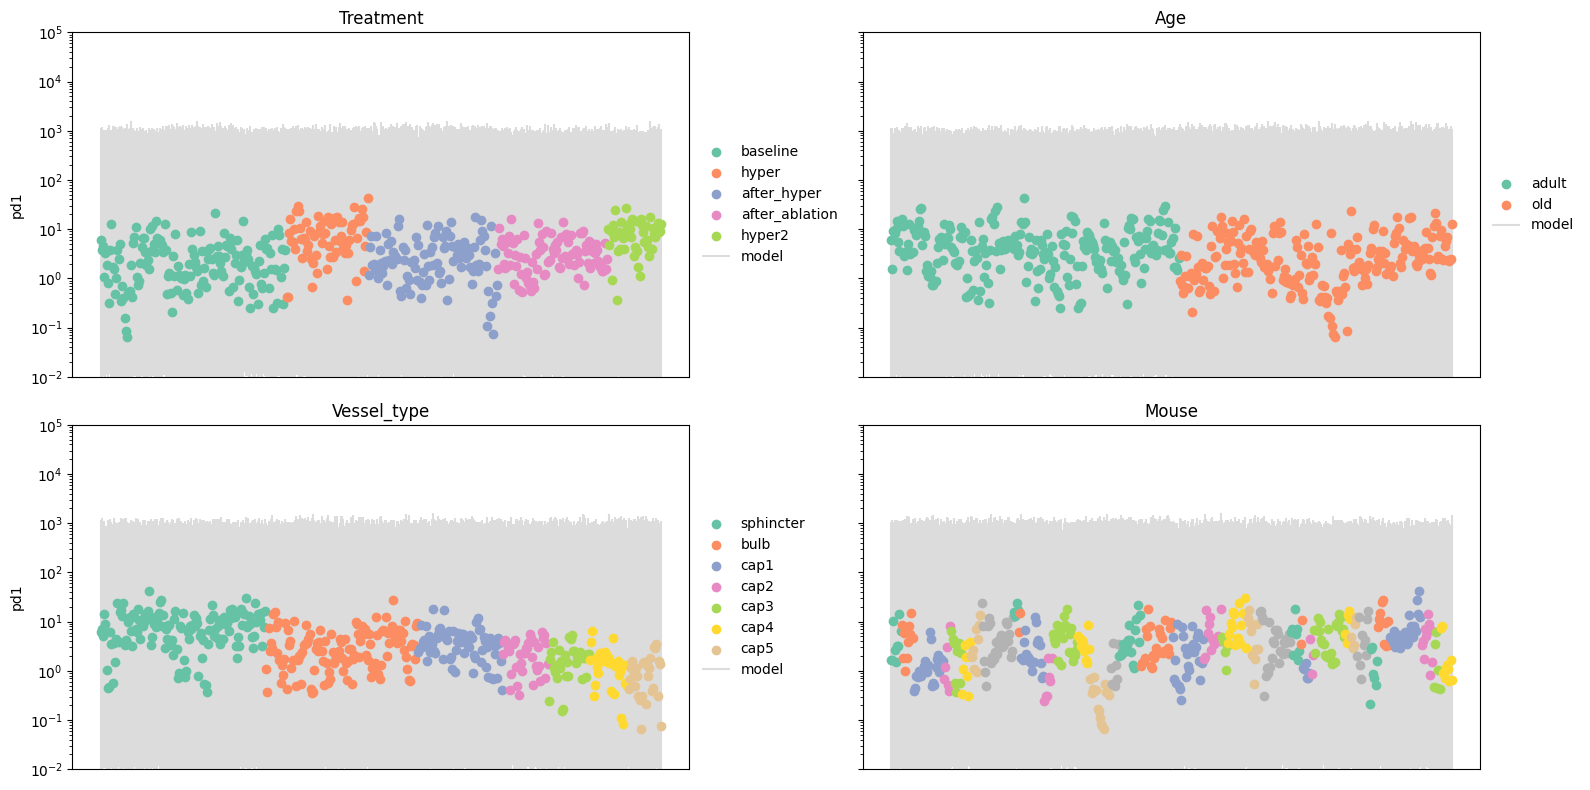

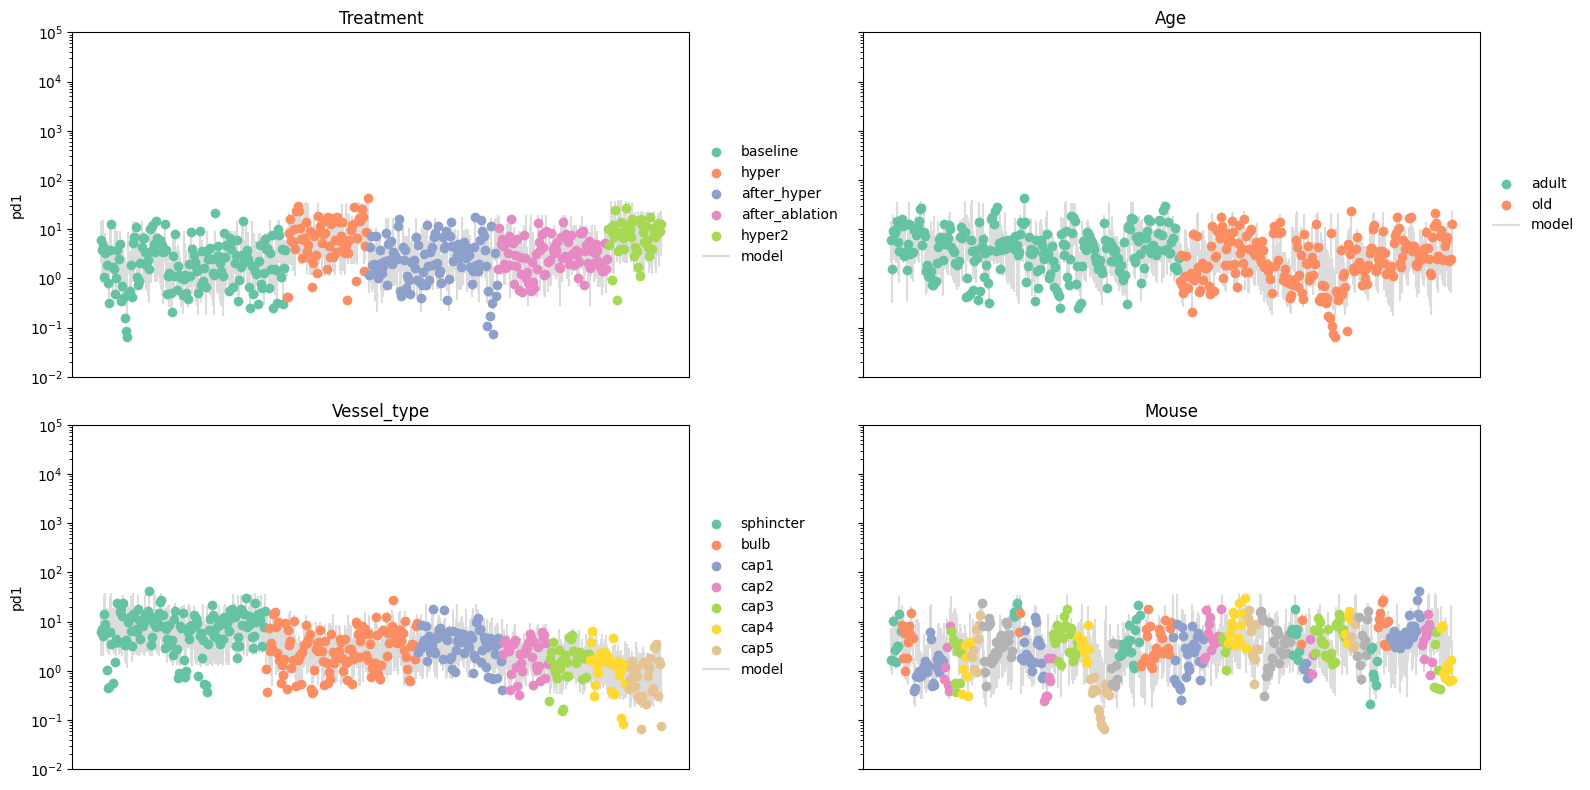

In [17]:
def plot_lines_cat(ax, yrep, catcol, cmap, **vlines_kwargs):
    colors = list(cmap.colors)
    d = pd.DataFrame(
        {
            "cat": catcol,
            "q1": yrep.quantile(0.01, dim=["chain", "draw"]).values,
            "q99": yrep.quantile(0.99, dim=["chain", "draw"]).values,
        }
    ).sort_values("cat").assign(x=np.linspace(0, 1, len(catcol)))
    linesets = []
    for i, (cat, subdf) in enumerate(d.groupby("cat", observed=True)):
        lines = ax.vlines(subdf["x"], subdf["q1"], subdf["q99"], color="gainsboro", **vlines_kwargs)
    return lines

def plot_ppc(axes, mts, obs, yrep, cmap):
    for (i, ax), col in zip(enumerate(axes), ["treatment", "age", "vessel_type", "mouse"]):
        catcol = mts[col].cat.remove_unused_categories()
        scts = plot_obs_cat(ax, obs, catcol, cmap)
        lines = plot_lines_cat(ax, yrep, catcol, cmap, zorder=0, label="model")
        if col != "mouse":
            ax.legend(scts + [lines], list(catcol.cat.categories) + ["model"], frameon=False, bbox_to_anchor=[1,0.5], loc="center left");
        if i % 2 == 0:
            ax.set_ylabel("pd1");
        ax.set_xticks([])
        ax.set_title(col.capitalize())
        ax.semilogy()
        ax.set_ylim(1e-2, 1e5)

cmap = plt.get_cmap("Set2")

for group, mode in zip(
    [idata.prior_predictive, idata.posterior_predictive], ["prior", "posterior"]
):
    yrep = group["yrep"]
    obs = msts["speed"]
    f, axes = plt.subplots(2, 2, figsize=[16, 8], sharey=True)
    axes = axes.ravel()
    axes = plot_ppc(axes, msts, obs, yrep, cmap)
    # f.suptitle(f"{mt.capitalize()} pulsatility measurements (first harmonic) vs {mode} simulations");
    f.tight_layout()
    # f.savefig(os.path.join(PLOTS_DIR, f"pulsatility-{mode}-check-{mt}.png"), bbox_inches="tight")

In [18]:
msts

,age,mouse,vessel_type,treatment,pressure_d,diameter,speed,flux
950,adult,100920,sphincter,baseline,53.504977,NaN,6.063019,383.344348
958,adult,100920,sphincter,hyper,NaN,NaN,14.819332,NaN
791,adult,130520,bulb,baseline,40.170137,NaN,0.765028,NaN
792,adult,130520,cap1,baseline,40.410177,NaN,1.781879,NaN
793,adult,130520,cap2,baseline,41.093826,NaN,0.629455,49.492191
...,...,...,...,...,...,...,...,...
1482,old,70921,sphincter,after_ablation,41.333767,NaN,8.286606,785.848162
1474,old,70921,sphincter,after_hyper,45.088534,NaN,11.644296,716.773283
1462,old,70921,sphincter,baseline,48.538426,NaN,9.300830,534.139593
1470,old,70921,sphincter,hyper,120.142216,NaN,23.386108,1004.509163


Add independent analysis of flux